In [1]:
import datetime, os
import tensorflow as tf
import tensorflow_datasets as tfds
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [ ]:
# Load dataset

dataset, info = tfds.load('oxford_iiit_pet', with_info=True)

In [3]:
def normalize(ds):
  image = tf.image.resize(ds['image'], (128, 128))
  mask = tf.image.resize(ds['segmentation_mask'], (128, 128))
  image= tf.cast(image, tf.float32) / 255.
  mask -= 1 
  return image, mask

In [4]:
# Normalize train and test

train = dataset['train'].map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(normalize, num_parallel_calls=tf.data.AUTOTUNE)

In [5]:
# Build the input pipeline

train = train.cache()
train = train.shuffle(info.splits['train'].num_examples)
train = train.batch(64)
train = train.prefetch(tf.data.AUTOTUNE)

test = test.cache()
test = test.batch(64)
test = test.prefetch(tf.data.AUTOTUNE)

In [6]:
# Define the base model: mobileNet transfer.

base_model = tf.keras.applications.MobileNetV2(weights='imagenet', input_shape=[128, 128, 3], include_top=False)

# Unfreeze last 4 layers

for layer in base_model.layers[:-4]:
  layer.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [7]:
# Define upsampling model

model = tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Conv2DTranspose(128, kernel_size=(3,3), strides=(2,2), activation='relu', kernel_initializer='he_normal', padding='same'))
model.add(tf.keras.layers.Conv2DTranspose(64, kernel_size=(3,3), strides=(2,2), activation='relu', kernel_initializer='he_normal', padding='same'))
model.add(tf.keras.layers.Conv2DTranspose(32, kernel_size=(3,3), strides=(2,2), activation='relu', kernel_initializer='he_normal', padding='same'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Conv2DTranspose(16, kernel_size=(3,3), strides=(2,2), activation='relu', kernel_initializer='he_normal', padding='same'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Conv2DTranspose(8, kernel_size=(3,3), strides=(2,2), activation='relu', kernel_initializer='he_normal', padding='same'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Conv2D(3, kernel_size=(3,3), activation='softmax', padding='same'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        1474688   
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 64)       73792     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 32, 32, 32)       18464     
 ranspose)                                                       
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0

In [8]:
# Model compilation

model.compile(optimizer='Adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [9]:
# Visualization functions

def display(display_list):
  plt.figure(figsize=(15, 15))
  title = ['Input Image', 'True Mask', 'Predicted Mask']
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

for images, masks in train.take(1):
  sample_image, sample_mask = images[0], masks[0]



In [10]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [11]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

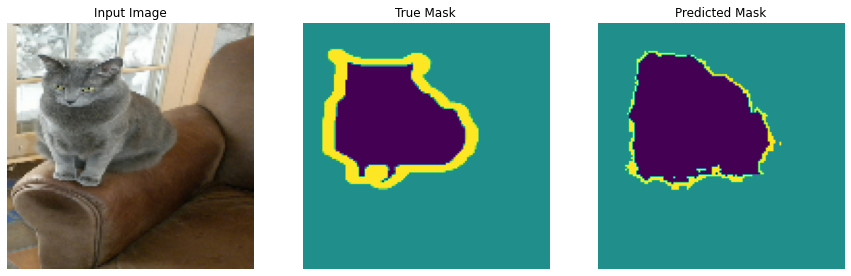


Sample Prediction after epoch 13

58/58 [==============================] - 210s 4s/step - loss: 0.2779 - accuracy: 0.8672 - val_loss: 0.7716 - val_accuracy: 0.7747


In [12]:
# Train the model

model.fit(train, epochs=13, validation_data=test, callbacks=[DisplayCallback()])